Aim: 
- check how strong spatial autocorrelation is for HCMC survey data
- test for global autocorrelation
- apply local Morans I for selected set of predictors

In [202]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely.geometry import Point, Polygon

import libpysal as lps
import pysal as ps
import esda
from scipy.spatial import Voronoi, voronoi_plot_2d
#from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, coords_to_points, points_to_coords

import contextily as cx
import mplleaflet as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_withGPS.xlsx")
#df_candidates = pd.read_excel("../input_survey_data/all-attributes_shophouses.xlsx")

# define as geoDF
#df_candidates["geometry"] = gpd.GeoSeries.from_wkt(df_candidates["geometry"])
#df_candidates = gpd.GeoDataFrame(df_candidates, crs="EPSG:4326", geometry="geometry")

# clean errorneous df
df_candidates.rename(columns={"geometry_pts": "geometry"}, inplace=True)

df_candidates = df_candidates.drop_duplicates(subset=['GPS'])
df_candidates = df_candidates[df_candidates['GPS'].notna()]
df_candidates = df_candidates[df_candidates['Target_direct_s'].notna()]
print(df_candidates.shape)


# set geometrc? crs 
#df_candidates = df_candidates.to_crs(3395)

(247, 29)


## make points as voronoi polygons
Code snippets: https://gis.stackexchange.com/questions/337561/making-polygon-for-every-point-in-set-using-voronoi-diagram

In [161]:
#df_candidates.geometry
#from shapely.ops import cascaded_union

## make bbox
bbox = np.asarray([ 
    [10.40, 106.75],
    [10.40, 106.35],
    [10.85, 106.35],
    [10.85, 106.75]
    ])
bbox = np.squeeze(bbox)
bbox = Polygon(bbox)
print(bbox.wkt)

POLYGON ((10.4 106.75, 10.4 106.35, 10.85 106.35, 10.85 106.75, 10.4 106.75))


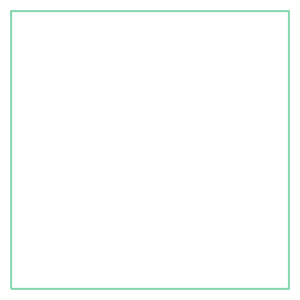

In [162]:
#Create a polygon
polygon = shapely.wkt.loads(bbox.wkt)
bound = polygon.buffer(200).envelope.boundary #Create a large rectangle surrounding it

#Create many points along the rectangle boundary. I create one every 100 m.
boundarypoints = [bound.interpolate(distance=d) for d in range(0, np.ceil(bound.length).astype(int), 1)]
boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])

bound

In [163]:
#Create the points inside the polygon

df = df_candidates
print(df.GPS[:2])

df["GPS"] = df["GPS"].apply(lambda x: np.array(x.split(","), dtype=np.float32))
coords = np.array(df["GPS"].values.tolist())
coords[0]

0      10.833199, 106.7438
1    10.831371, 106.742649
Name: GPS, dtype: object


array([ 10.833199, 106.7438  ], dtype=float32)

In [164]:
# vor = Voronoi(coords)
# vor
# fig = voronoi_plot_2d(vor)
# plt.show()  # blue = obs from survey

<Axes: >

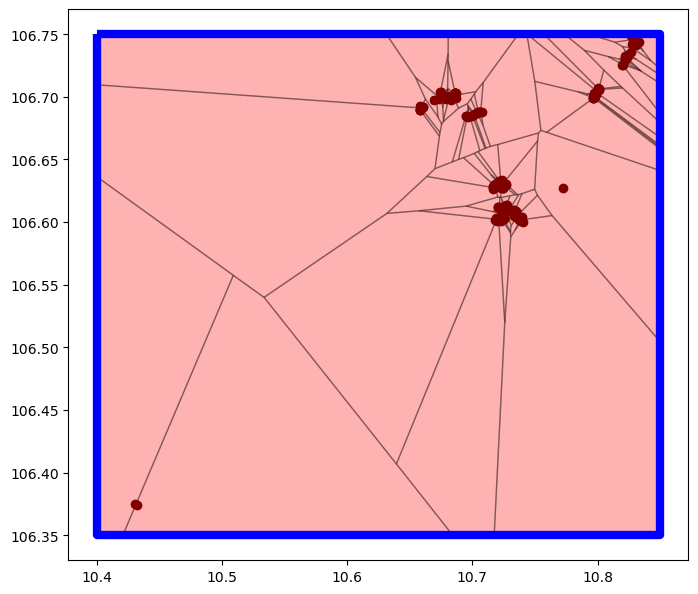

In [165]:
## TODO : change to appropiate metric epsg eg. 32643 or 8559. (curr crs: 3006)

all_coords = np.concatenate((boundarycoords, coords)) #Create an array of all points on the boundary and inside the polygon

vor = Voronoi(points=all_coords)
lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]

polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:3006")

polydf = gpd.GeoDataFrame(geometry=[polygon], crs="epsg:3006")
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=coords[:,0], y=coords[:,1], crs="epsg:3006"))

result = gpd.overlay(df1=voronois, df2=polydf, how="intersection")

fig, ax = plt.subplots(figsize=(8, 8))
polydf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6)
result.plot(ax=ax, color="red", alpha=0.3, edgecolor="black")
points.plot(ax=ax, color="maroon")
# coords_survey = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=df.GPS.apply(lambda x: x[0]), y=df.GPS.apply(lambda x: x[1]), crs="epsg:3006"))
# coords_survey


In [166]:
df = pd.concat([df, result], axis=1, ignore_index=False)
df.rename(columns={"centroids": "GPS"}, inplace=True)
df.head(2)


,Target_direct_s,Target_direct_r,Q0.1,shp_closed_d,shp_duration_back2normal,business_reduction_s,business_reduction_r,inundation_duration_h,water_depth_cm,contaminations,...,shp_damage_level_products,shp_sector,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,GPS,geometry,geometry
0,30.0,30.0,4.020000e+12,0.0,0.0,30.0,30.0,48.0,120.0,1.0,...,3.0,15.0,2.0,2.0,100.0,1.0,1.0,"[10.833199, 106.7438]",POINT (106.7438 10.833199),"POLYGON ((10.673 106.684, 10.675 106.678, 10.6..."
1,97.0,0.0,2.010010e+12,7.0,30.0,30.0,0.0,4.0,90.0,2.0,...,4.0,21.0,7.0,4.0,3000.0,4.0,5.0,"[10.831371, 106.742645]",POINT (106.742649 10.831371),"POLYGON ((10.662 106.698, 10.654 106.716, 10.6..."


In [167]:
# #Calculate Voronoi Regions
# poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, polygon.buffer(0.001))

# fig, ax = subplot_for_map()
# plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments)
# ax.set_title('Voronoi regions of Schools in Uppsala')
# plt.tight_layout()
# plt.show()

df.columns = [*df.columns[:-1], 'geometry_polys']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 0 to 241
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Target_direct_s                     247 non-null    float64 
 1   Target_direct_r                     244 non-null    float64 
 2   Q0.1                                247 non-null    float64 
 3   shp_closed_d                        247 non-null    float64 
 4   shp_duration_back2normal            247 non-null    float64 
 5   business_reduction_s                247 non-null    float64 
 6   business_reduction_r                246 non-null    float64 
 7   inundation_duration_h               247 non-null    float64 
 8   water_depth_cm                      247 non-null    float64 
 9   contaminations                      247 non-null    float64 
 10  warning_time_h                      247 non-null    float64 
 11  emergency_measures                  2

In [168]:
df = df[df['geometry'].notna()]
df = df[df['Target_direct_s'].notna()]
df.shape

(247, 30)

## Global Moran’s I 

cide snippets: https://pysal.org/esda/notebooks/spatialautocorrelation.html

In [189]:
## use survey data points for weights creation - using KNN or DistanceBand neighborhodd definition

dff = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df["geometry"]))
wq =  lps.weights.DistanceBand.from_dataframe(dff, alpha=-1.0, threshold=0.06)  # def -1.0
wq.transform = 'r'

## use voronoi polygons for weights creation - using Queens neighborhodd defnition

# wq = lps.weights.contiguity.Queen.from_dataframe(df)
#.lib.weights.Queen.from_dataframe(df)
# wq.transform = 'r'



c:\Anaconda\envs\py396_c3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


Median of direct loss cost from most serious floods 0.0


C:\Users\Anna\AppData\Local\Temp\ipykernel_14544\3219330412.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mi.sim, shade=True)


Moran’s I 0.000869753163509757
p-value: 0.017
z-score :


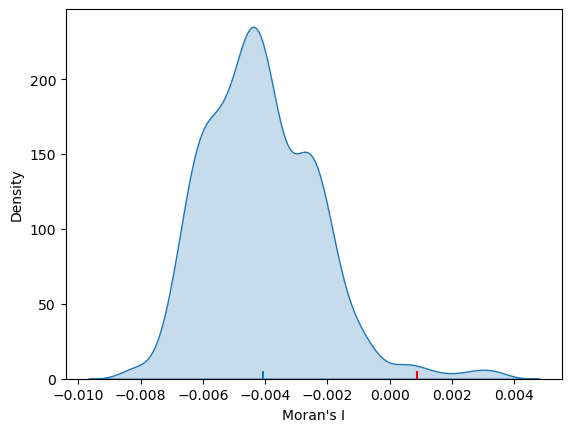

In [191]:
print("Median of direct loss cost from most serious floods", df['Target_direct_s'].median())

## Moran’s I is a test for global autocorrelation for a continuous attribute:
#np.random.seed(12345)
mi = esda.moran.Moran(dff['Target_direct_s'], wq)

sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 5, color='r')
plt.vlines(mi.EI, 0,5)
plt.xlabel("Moran's I")

print("Moran’s I", mi.I)  # = red == observed value

print("p-value:", mi.p_sim)  # significant <=0.05
print("z-score :")  #  statement with a given level of confidence about whether or not we reject or accept the null hypothesis. 



#### Summary of global Morans I and tested neighborhood methods for creating weights 

- depending on the used method medium to slight spatial autocorrelation exists in the target variable (direct loss costs for buiness contents) using survey data points

point weights -distance-based methods : 
- Kernel: Moran’s I 0.004104969180819566, p-value: 0.024  
- KNN :  -0.00200017350371295, p: 0.204
- DistanceBand, thresh=0.06: Moran’s I 0.000869753163509757, p-value: 0.017

voronoi-polygon weights : 
- KNN: Moran’s I -0.005188730674930613, p-value: 0.411   
- .contiguity.Queen: Moran’s I 0.0008359166369407995, p-value: 0.108  ## contiguity-based method depending on polygons


## Local Moran’s I 

code snippets from: https://pysal.org/esda/notebooks/spatialautocorrelation.html

In [ ]:
## same weights as for global Morans I

# dff = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df["geometry"]))
# wq =  lps.weights.DistanceBand.from_dataframe(dff, alpha=-1.0, threshold=0.06)  # def -1.0
# wq.transform = 'r'

In [192]:
li = esda.moran.Moran_Local(dff['Target_direct_s'], wq)
li.q


array([2, 1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3])

In [211]:
# We can again test for local clustering using permutations, but here we use conditional random permutations (different distributions for each focal location)

(li.p_sim < 0.05).sum()

# We can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot above:

sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

# set new crs whic is needed for background map
dff_plot = dff.set_crs("EPSG:4326")


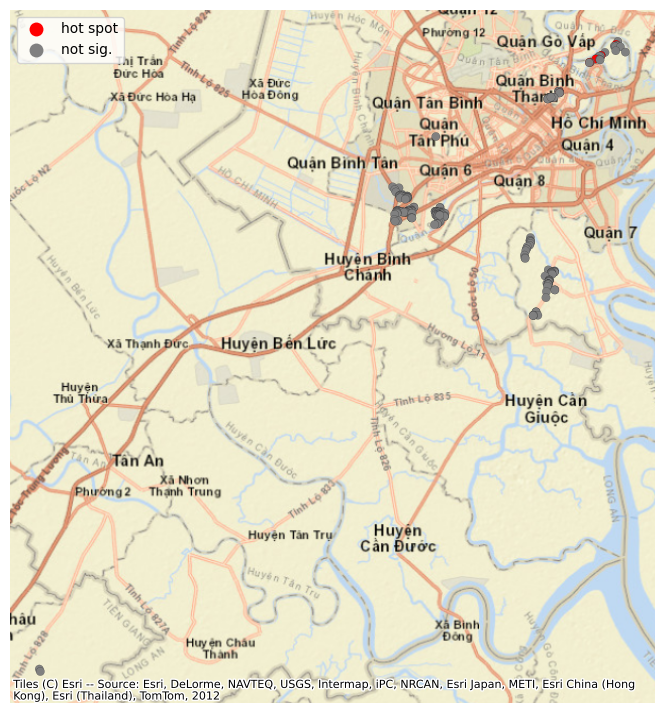

In [214]:

spots = ['not sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

hmap = colors.ListedColormap(['red', 'grey'])
f, ax = plt.subplots(1, figsize=(9, 9))
dff.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='black', legend=True)
ax.set_axis_off()
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.

plt.show()


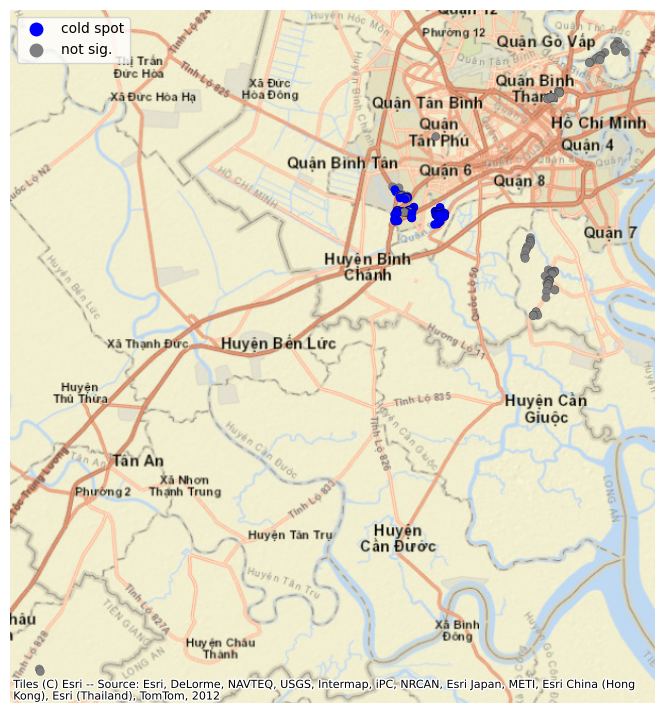

In [216]:
spots = ['not sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

hmap = colors.ListedColormap(['blue', 'grey'])
f, ax = plt.subplots(1, figsize=(9, 9))
dff.assign(cl=labels).plot(column='cl', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax, 
        edgecolor='black', legend=True)
ax.set_axis_off()
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.

plt.show()



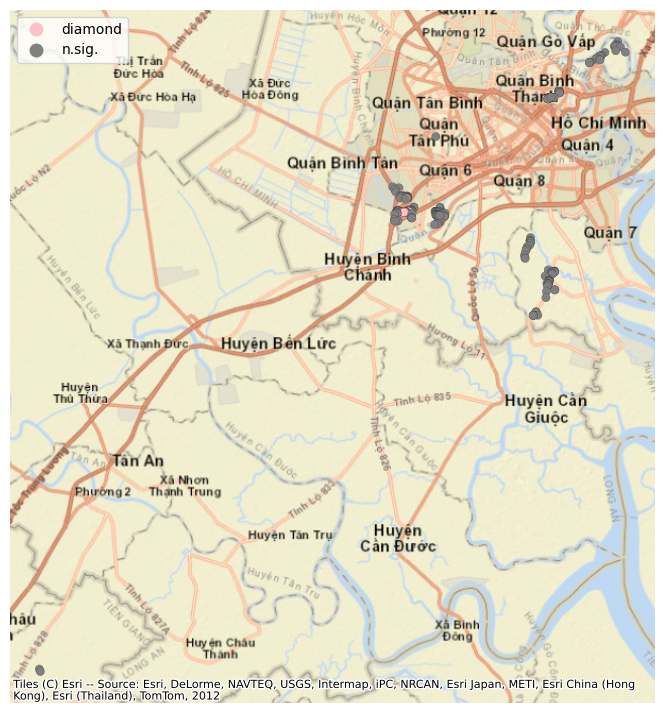

In [222]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

hmap = colors.ListedColormap(['pink', 'grey'])
f, ax = plt.subplots(1, figsize=(9, 9))
dff.assign(cl=labels).plot(column='cl', categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax, 
        edgecolor='black', legend=True)
ax.set_axis_off()
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.

plt.show()

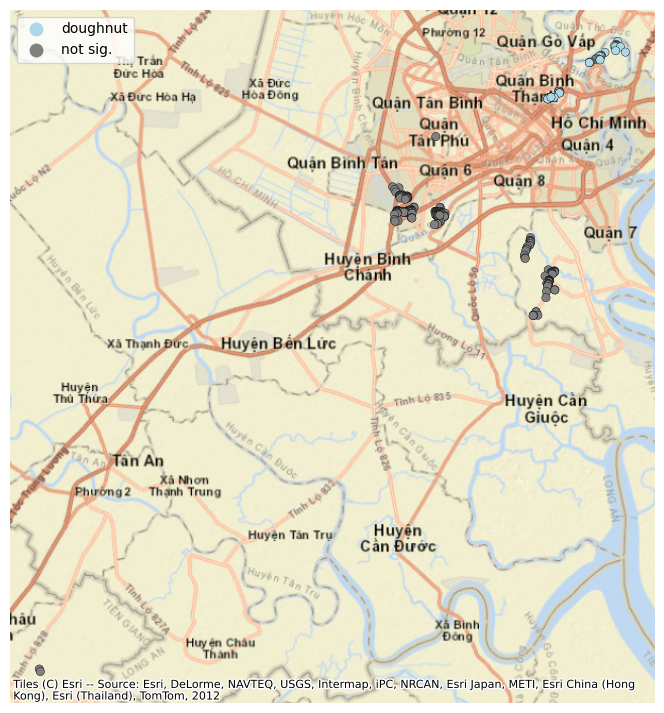

In [221]:
spots = ['not sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

hmap = colors.ListedColormap(['lightblue', 'grey'])
f, ax = plt.subplots(1, figsize=(9, 9))
ax = dff_plot.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.3, ax=ax,
       edgecolor='black', legend=True)
ax.set_axis_off()
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.
                         

plt.show()

#### Summarize local autocorrelation for target 

- direct loss costs for business contents are clustering for the observed area of HCMC
- clusters of very high as also for very low loss costs exists
- within the hot spot (in north-east) quite many businesses occure with unexpected low loss costs
- both clusters of high and low loss costs seems to be located around tributaries of the Mekong - but this assumtion needs to be examined more if really high water levels from the tributary rivers influence the loss costs



In [ ]:
## Plot spaital lag of morans i

# np.random.seed(12345)
# import esda
# wq.transform = 'r'
# lag_price = lps.weights.lag_spatial(wq, df['median_pri'])

# price = df['median_pri']
# b, a = np.polyfit(price, lag_price, 1)
# f, ax = plt.subplots(1, figsize=(9, 9))

# plt.plot(price, lag_price, '.', color='firebrick')

#  # dashed vert at mean of the price
# plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
#  # dashed horizontal at mean of lagged price
# plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# # red line of best fit using global I as slope
# plt.plot(price, a + b*price, 'r')
# plt.title('Moran Scatterplot')
# plt.ylabel('Spatial Lag of Price')
# plt.xlabel('Price')
# plt.show()

